In [1]:
import kagglehub
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from trainer import Trainer

#import Dataloader
from dataloader import ImageColorizerDataset

#import architectures
from neural_nets import ImageColorizer, ImageSuperRes, UNet, UNetRes

/Users/gabrielmindlberger/Library/Mobile Documents/com~apple~CloudDocs/FH-AI/Sem2/ML/PRO/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gabrielmindlberger/Library/Mobile Documents/com~apple~CloudDocs/FH-AI/Sem2/ML/PRO/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
IMAGE_PATH = kagglehub.dataset_download("arnaud58/landscape-pictures")
print("Path to dataset files:", IMAGE_PATH)

Path to dataset files: /Users/gabrielmindlberger/.cache/kagglehub/datasets/arnaud58/landscape-pictures/versions/2


In [3]:
# 2. Device config
device = torch.device(
    'mps' if torch.backends.mps.is_available()
    else 'cuda' if torch.cuda.is_available()
    else 'cpu'
)

print(f'Using device: {device}')

Using device: mps


In [4]:
# 3. Hyperparameters
img_height, img_width = 128, 128
batch_size            = 16
num_epochs            = 10
learning_rate         = 1e-3

In [5]:
# 6. DataLoader
dataset   = ImageColorizerDataset(IMAGE_PATH, img_height, img_width)

val_frac  = 0.1
n_total   = len(dataset)
n_val     = int(n_total * val_frac)
n_train   = n_total - n_val

# 3) Splitten
train_ds, val_ds = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print(f'Loaded {len(dataset)} images.')

Loaded 4319 images.


In [6]:
model = ImageColorizer(in_channels=1, out_channels=3)                               #UNetResidual
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

ImageColorizer(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up1): Upsample(scale_factor=2.0, mode='nearest')
  (dec1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up2): Upsample(scale_factor=2.0, mode='nearest')
  (dec2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (final): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (sigmoid): Sigmoid()
)


In [ ]:
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device)
trainer.fit(num_epochs=20)

# 4) Lernkurve anzeigen
trainer.plot_history()

  Train:   0%|          | 0/270 [00:00<?, ?it/s]

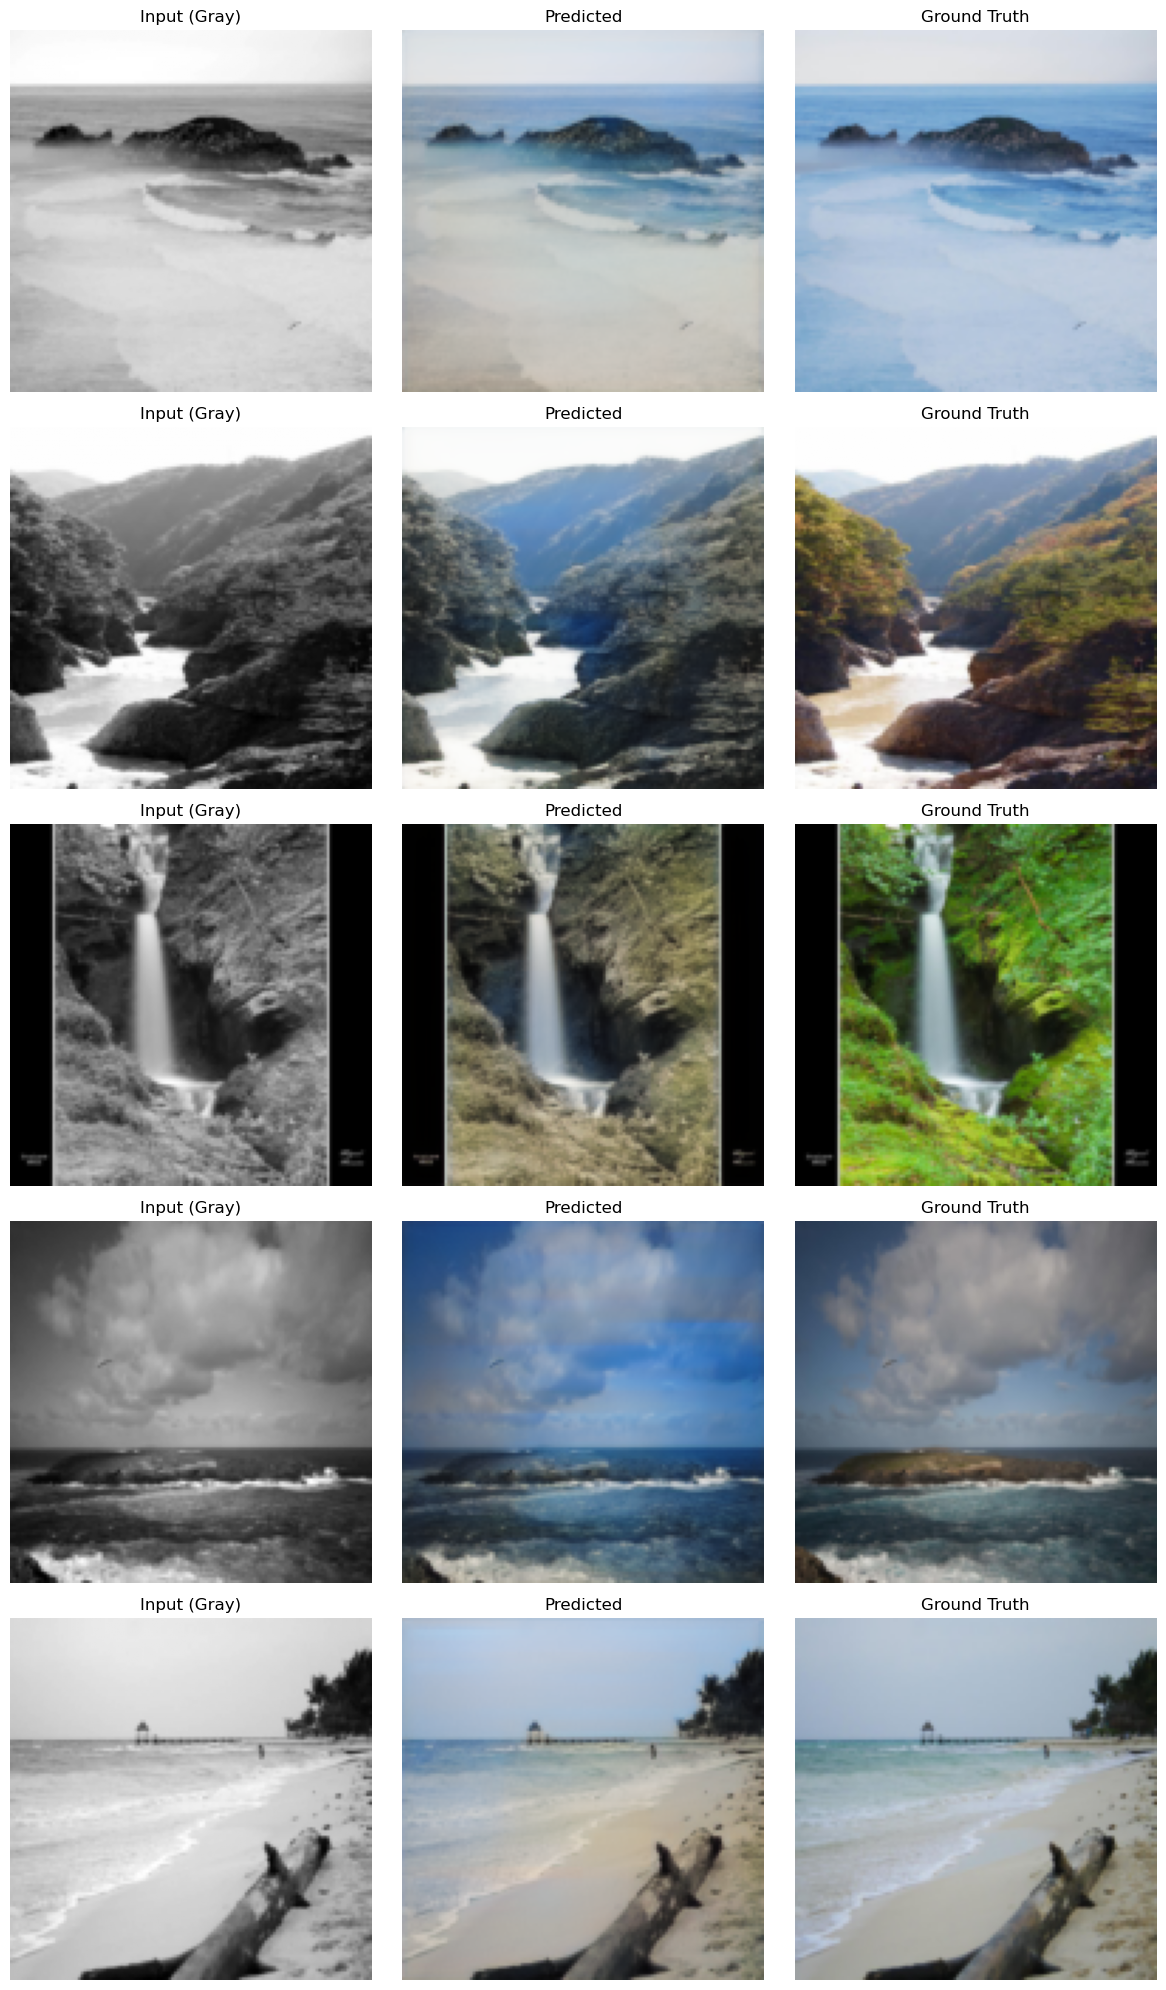

In [22]:
# 10. Ergebnisse anzeigen
model.eval()
with torch.no_grad():
    gray_batch, true_color_batch = next(iter(dataloader))
    gray_batch  = gray_batch.to(device)
    pred_batch  = model(gray_batch).cpu()

n_display = min(5, gray_batch.size(0))
fig, axes = plt.subplots(n_display, 3, figsize=(12, 4 * n_display))
for i in range(n_display):
    axes[i,0].imshow(gray_batch[i].cpu().squeeze(), cmap='gray')
    axes[i,0].set_title('Input (Gray)')
    axes[i,0].axis('off')

    axes[i,1].imshow(pred_batch[i].permute(1,2,0))
    axes[i,1].set_title('Predicted')
    axes[i,1].axis('off')

    axes[i,2].imshow(true_color_batch[i].permute(1,2,0))
    axes[i,2].set_title('Ground Truth')
    axes[i,2].axis('off')

plt.tight_layout()
plt.show()